# NVIDIA AI Playground Embedding Models

>[NVIDIA AI Playground](https://www.nvidia.com/en-us/research/ai-playground/) gives users easy access to hosted endpoints for generative AI models like Llama-2, SteerLM, Mistral, etc. Using the API, you can query NVCR (NVIDIA Container Registry) function endpoints and get quick results from a DGX-hosted cloud compute environment. All models are source-accessible and can be deployed on your own compute cluster.

This example goes over how to use LangChain to interact with supported the NVOLVE question-answer embedding model [(NGC AI Playground entry in NGC)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-29k). 
For more information on the accessing the chat models through this api, check out the [ChatNVAIPlay](../chat/nv_aiplay) documentation.

## Installation

In [ ]:
%pip install -U --quiet langchain-nvidia-aiplay

## Setup

**To get started:**
1. Create a free account with the [NVIDIA GPU Cloud](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.
2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.
3. Select the `API` option and click `Generate Key`.
4. Save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [5]:
import getpass
import os

## API Key can be found by going to NVIDIA NGC -> AI Playground -> (some model) -> Get API Code or similar.
## 10K free queries to any endpoint (which is a lot actually).

# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

NVAPI Key (starts with nvapi-):  ········


We should be able to see an embedding model among that list which can be used in conjunction with an LLM for effective RAG solutions. We can interface with this model pretty easily with the help of the `NVAIEmbeddings` model.

## Initialization

The main requirement when initializing an embedding model is to provide the model name. An example is `nvolveqa_40k` below.

For `nvovleqa_40k`, you can also specify the `model_type` as `passage` or `query`. When doing retrieval, you will get best results if you embed the source documents with the `passage` type and the user queries with the `query` type.

If not provided, the `embed_query` method will default to the `query` type, and the `embed_documents` mehod will default to the `passage` type.

In [6]:
from langchain_nvidia_aiplay import NVAIPlayEmbeddings

embedder = NVAIPlayEmbeddings(model="nvolveqa_40k")

# Alternatively, if you want to specify whether it will use the query or passage type
# embedder = NVAIPlayEmbeddings(model="nvolveqa_40k", model_type="passage")

This model is a fine-tuned E5-large model which supports the expected `Embeddings`` methods including:
- `embed_query`: Generate query embedding for a query sample.
- `embed_documents`: Generate passage embeddings for a list of documents which you would like to search over.
- `aembed_quey`/`embed_documents`: Asynchronous versions of the above.

### **Similarity/Speed Test**

The following is a quick test of the methods in terms of usage, format, and speed for the use case of embedding the following data points:

**Queries:**
- What's the weather like in Komchatka?
- What kinds of food is Italy known for?
- What's my name? I bet you don't remember...
- What's the point of life anyways?
- The point of life is to have fun :D

**Documents:**
- Komchatka's weather is cold, with long, severe winters.
- Italy is famous for pasta, pizza, gelato, and espresso.
- I can't recall personal names, only provide information.
- Life's purpose varies, often seen as personal fulfillment.
- Enjoying life's moments is indeed a wonderful approach.

### Embedding Runtimes

In [14]:
import time

print("Single Query Embedding: ")
s = time.perf_counter()
q_embedding = embedder.embed_query("What's the weather like in Komchatka?")
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embedding),))

print("\nSequential Embedding: ")
s = time.perf_counter()
q_embeddings = [
    embedder.embed_query("What's the weather like in Komchatka?"),
    embedder.embed_query("What kinds of food is Italy known for?"),
    embedder.embed_query("What's my name? I bet you don't remember..."),
    embedder.embed_query("What's the point of life anyways?"),
    embedder.embed_query("The point of life is to have fun :D"),
]
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

print("\nBatch Query Embedding: ")
s = time.perf_counter()
# To use the "query" mode, we have to add it as an instance arg
q_embeddings = NVAIPlayEmbeddings(
    model="nvolveqa_40k", model_type="query"
).embed_documents(
    [
        "What's the weather like in Komchatka?",
        "What kinds of food is Italy known for?",
        "What's my name? I bet you don't remember...",
        "What's the point of life anyways?",
        "The point of life is to have fun :D",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

Single Query Embedding: 
Executed in 0.62 seconds.
Shape: (1024,)

Sequential Embedding: 
Executed in 2.35 seconds.
Shape: (5, 1024)

Batch Query Embedding: 
Executed in 0.79 seconds.
Shape: (5, 1024)


### Document Embedding

In [15]:
import time

print("Single Document Embedding: ")
s = time.perf_counter()
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embedding),))

print("\nBatch Document Embedding: ")
s = time.perf_counter()
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

Single Document Embedding: 
Executed in 0.36 seconds.
Shape: (1024,)

Batch Document Embedding: 
Executed in 0.77 seconds.
Shape: (5, 1024)


Now that we've generated out embeddings, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task:

In [19]:
%pip install --quiet matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


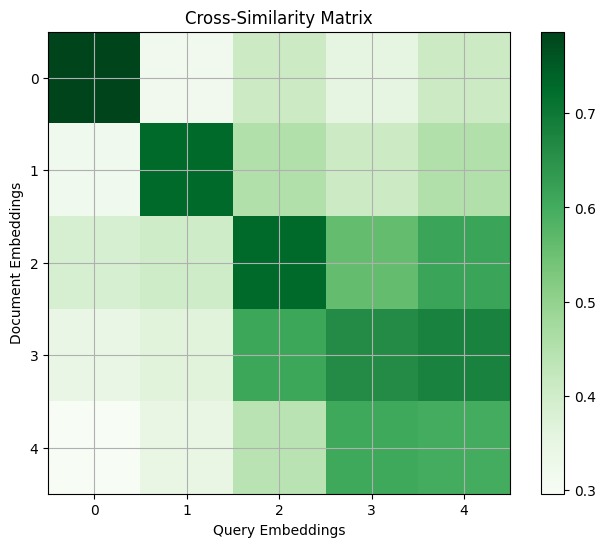

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming embeddings1 and embeddings2 are your two sets of vectors
# Compute the similarity matrix between embeddings1 and embeddings2
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**
- What's the weather like in Komchatka?
- What kinds of food is Italy known for?
- What's my name? I bet you don't remember...
- What's the point of life anyways?
- The point of life is to have fun :D

**Documents:**
- Komchatka's weather is cold, with long, severe winters.
- Italy is famous for pasta, pizza, gelato, and espresso.
- I can't recall personal names, only provide information.
- Life's purpose varies, often seen as personal fulfillment.
- Enjoying life's moments is indeed a wonderful approach.

## RAG Retrieval:

The following is a repurposing of the initial example of the [LangChain Expression Language Retrieval Cookbook entry](
https://python.langchain.com/docs/expression_language/cookbook/retrieval), but executed with NVIDIA AI Playground's [Mistral 7B Instruct](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/mistral-7b-instruct) and [NVOLVE Retrieval QA Embedding](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-29k) models. The subsequent examples in the cookbook also run as expected, and we encourage you to explore with these options.

**TIP:** We would recommend using Mistral for internal reasoning (i.e. instruction following for data extraction, tool selection, etc.) and Llama-Chat for a single final "wrap-up by making a simple response that works for this user based on the history and context" response.

In [10]:
!pip install langchain faiss-cpu tiktoken -q

from operator import itemgetter

from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_nvidia_aiplay import ChatNVAIPlay

In [11]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"],
    embedding=NVAIPlayEmbeddings(model="nvolveqa_40k"),
)
retriever = vectorstore.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

model = ChatNVAIPlay(model="mixtral_8x7b")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("where did harrison work?")

'Based on the document provided, Harrison worked at Kensho.'

In [13]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer using information solely based on the following context:\n<Documents>\n{context}\n</Documents>"
            "\nSpeak only in the following language: {language}",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})

'Harrison ha lavorato presso Kensho.\n\n(In English: Harrison worked at Kensho.)'